In [1]:
# Libraries used
using DataFrames;
using CSV;
using Statistics;
using Random;
using StatsPlots;
using ScikitLearn;
@sk_import decomposition:PCA;
@sk_import impute: KNNImputer;
include("utils/preprocessing.jl");
include("utils/visualizations.jl");

# Load dataset

In [2]:
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# Hold-out partition

In [3]:
using Random;

# trainIndex, testIndex = holdOut(nrow(support2), 0.2);
trainIndex, testIndex = holdOut(nrow(support2), 0.2)

# The two final variables are death and hospdead (last one)
trainInput = support2[trainIndex,1:end-2];
trainOutput = support2[trainIndex,end-1];
testInput = support2[testIndex,1:end-2];
testOutput = support2[testIndex,end-1];

show(first(trainInput,2), allcols=true, allrows=true)

2×56 DataFrame
 Row │ age      slos   d.time  num.co  edu      scoma  charges  totcst   avtisst  sps      aps    surv2m    surv6m    hday   prg2m    prg6m    dnrday  meanbp   wblc     hrt      resp     temp     pafi     bili      crea     sod      ph       adls     adlsc    income_ord  ca_ord  sfdm2_ord  dementia  diabetes  sex_male  sex_female  dzgroup_Lung Cancer  dzgroup_Cirrhosis  dzgroup_ARF/MOSF w/Sepsis  dzgroup_Coma  dzgroup_CHF  dzgroup_Colon Cancer  dzgroup_COPD  dzgroup_MOSF w/Malig  dzclass_Cancer  dzclass_COPD/CHF/Cirrhosis  dzclass_ARF/MOSF  dzclass_Coma  race_other  race_white  race_black  race_hispanic  race_asian  dnr_no dnr  dnr_dnr after sadm  dnr_dnr before sadm 
     │ Float64  Int64  Int64   Int64   Float64  Int64  Float64  Float64  Float64  Float64  Int64  Float64   Float64   Int64  Float64  Float64  Int64   Float64  Float64  Float64  Float64  Float64  Float64  Float64   Float64  Float64  Float64  Float64  Float64  Float64     Int64   Float64    Int64     Int64  

# Imputation

In [4]:
imputer = KNNImputer(n_neighbors = 2)

trainInput[:,1:32] = fit_transform!(imputer, Matrix(trainInput[:,1:32]));
testInput[:,1:32] = imputer.transform(Matrix(testInput[:,1:32]));

show(first(trainInput,2), allcols=true, allrows=true)

2×56 DataFrame
 Row │ age      slos   d.time  num.co  edu      scoma  charges  totcst   avtisst  sps      aps    surv2m    surv6m    hday   prg2m    prg6m    dnrday  meanbp   wblc      hrt      resp     temp     pafi     bili      crea     sod      ph       adls     adlsc    income_ord  ca_ord  sfdm2_ord  dementia  diabetes  sex_male  sex_female  dzgroup_Lung Cancer  dzgroup_Cirrhosis  dzgroup_ARF/MOSF w/Sepsis  dzgroup_Coma  dzgroup_CHF  dzgroup_Colon Cancer  dzgroup_COPD  dzgroup_MOSF w/Malig  dzclass_Cancer  dzclass_COPD/CHF/Cirrhosis  dzclass_ARF/MOSF  dzclass_Coma  race_other  race_white  race_black  race_hispanic  race_asian  dnr_no dnr  dnr_dnr after sadm  dnr_dnr before sadm 
     │ Float64  Int64  Int64   Int64   Float64  Int64  Float64  Float64  Float64  Float64  Int64  Float64   Float64   Int64  Float64  Float64  Int64   Float64  Float64   Float64  Float64  Float64  Float64  Float64   Float64  Float64  Float64  Float64  Float64  Float64     Int64   Float64    Int64     Int64

# Standardize

In [5]:
X_train = Matrix(trainInput);
X_test = Matrix(testInput);
y_train = trainOutput;
y_test = testOutput

meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(Matrix(X_train[:,1:32]));

X_train[:,1:32] = normalizeZeroMean!(Matrix(X_train[:,1:32]), (meanTrain, stdTrain));
X_test[:,1:32] = normalizeZeroMean!(Matrix(X_test[:,1:32]), (meanTrain, stdTrain));

In [6]:
X_train[1:2,:]

2×56 Matrix{Float64}:
 1.64971   -0.310402   0.509062  …  1.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.455551   1.61761   -0.132236     1.0  0.0  0.0  0.0  1.0  0.0  0.0

In [7]:
y_train[1:2]

2-element Vector{Int64}:
 0
 0

# Correlations

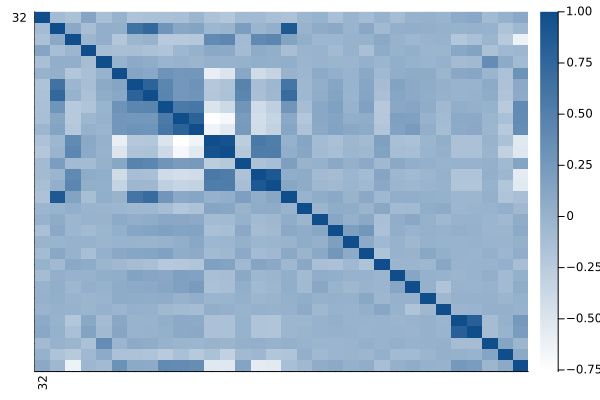

In [8]:
M = cor(Matrix(X_train[:, 1:32]))
(n,m) = size(M)

heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,32), xrot=90, yticks=(1:m,32), yflip=true)

# PCA

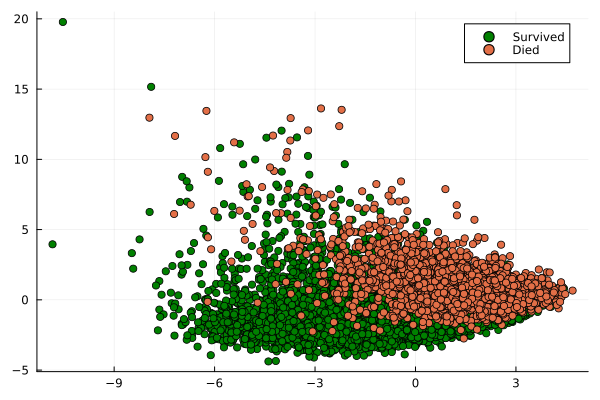

In [9]:
#Define the PCA object and the number of componentes that are desired
pca = PCA(2)

#Ajust the matrix acording to the train data
fit!(pca, X_train)

#Once it is ajusted it can be used to transform the data
pca_train = pca.transform(X_train)

# Draw results
draw_results(pca_train, y_train; colors=[:green,:red], target_names=["Survived", "Died"])

# Select k best

In [18]:
@sk_import svm: SVC
model = SVC();
fit!(model, X_train, y_train);

In [20]:
@sk_import feature_selection: SelectKBest
@sk_import feature_selection: f_classif


#Define the PCA object and the number of componentes that are desired
selector = SelectKBest(f_classif, k=10);
X_selected = fit_transform!(selector, X_train, y_train);

model = SVC();
fit!(model, X_selected, y_train)

PyObject SVC()